In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Importing all required modules. 

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score


from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
BATCH_SIZE = 8
EPOCHS = 20
IMAGE_SIZE = (512, 512)
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(10)

# Importing data from dataset.

In [4]:
for dirname, _, filenames in os.walk('../input/chest-xray-pneumonia/chest_xray/chest_xray/'):
    print(dirname)

../input/chest-xray-pneumonia/chest_xray/chest_xray/
../input/chest-xray-pneumonia/chest_xray/chest_xray/val
../input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA
../input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL
../input/chest-xray-pneumonia/chest_xray/chest_xray/test
../input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA
../input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL
../input/chest-xray-pneumonia/chest_xray/chest_xray/train
../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA
../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL


In [5]:
filenames = tf.io.gfile.glob('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/*/*')
filenames.extend(tf.io.gfile.glob('../input/chest-xray-pneumonia/chest_xray/chest_xray/test/*/*'))
filenames[:3]

['../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1230_virus_2081.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1513_virus_2632.jpeg']

# Arranging in the form of tables.

In [6]:
data = pd.DataFrame()
for el in range(0, len(filenames)):
    target = filenames[el].split('/')[-2]
    path = filenames[el]
    data.loc[el, 'filename'] = path
    data.loc[el, 'class'] = target

print(data['class'].value_counts(dropna=False))
data[:10]

PNEUMONIA    4266
NORMAL       1576
Name: class, dtype: int64


,filename,class
0,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
5,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
6,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
7,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
8,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
9,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA


## Changing order of the table.

In [7]:
data = shuffle(data, random_state=42)
data.reset_index(drop=True, inplace=True)
data[:10]

,filename,class
0,../input/chest-xray-pneumonia/chest_xray/chest...,NORMAL
1,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
5,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
6,../input/chest-xray-pneumonia/chest_xray/chest...,NORMAL
7,../input/chest-xray-pneumonia/chest_xray/chest...,NORMAL
8,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
9,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA


## Spliting the Test_data and train_data.

In [8]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42, stratify=data['class'])
print(test_data.shape)
test_data = test_data[ : test_data.shape[0] // BATCH_SIZE * BATCH_SIZE]
print(test_data.shape)
print(train_data['class'].value_counts(dropna=False))
print(test_data['class'].value_counts(dropna=False))

(585, 2)
(584, 2)
PNEUMONIA    3839
NORMAL       1418
Name: class, dtype: int64
PNEUMONIA    426
NORMAL       158
Name: class, dtype: int64


## Spliting the Test_data and val_data.

In [9]:
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data['class'])
print(train_data['class'].value_counts(dropna=False))
print(val_data['class'].value_counts(dropna=False))

PNEUMONIA    3455
NORMAL       1276
Name: class, dtype: int64
PNEUMONIA    384
NORMAL       142
Name: class, dtype: int64


# defining Image Data Generator for test_data.

In [10]:
# Declare an image generator for image augmentation
datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, # 0.05
                             brightness_range=[0.9, 1.0],
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=10,  # 5
                            )


test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = datagen.flow_from_dataframe(train_data,
                                        target_size=(IMAGE_SIZE),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True,
                                        num_parallel_calls=AUTOTUNE)

val_gen = test_datagen.flow_from_dataframe(val_data,
                                        target_size=(IMAGE_SIZE),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

test_gen = test_datagen.flow_from_dataframe(test_data,
                                        target_size=(IMAGE_SIZE),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

Found 4729 validated image filenames belonging to 2 classes.
Found 526 validated image filenames belonging to 2 classes.
Found 584 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [11]:
train_ds = tf.data.Dataset.from_generator(lambda: train_gen,
                                            output_types=(tf.float32, tf.int32),
                                            output_shapes=([None, *IMAGE_SIZE, 1], [None, ]))

val_ds = tf.data.Dataset.from_generator(lambda: val_gen,
                                          output_types=(tf.float32, tf.int32),
                                          output_shapes=([None, *IMAGE_SIZE, 1], [None, ]))

test_ds = tf.data.Dataset.from_generator(lambda: test_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, *IMAGE_SIZE, 1], [None, ]))

2022-02-22 16:48:57.044565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 16:48:57.156020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 16:48:57.156913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 16:48:57.162781: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Augmented Data.

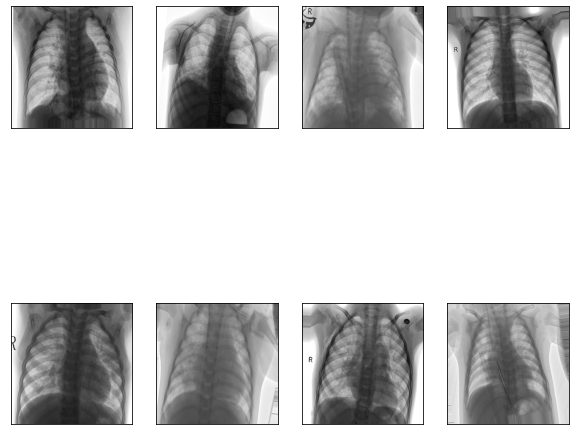

In [12]:
plt.figure(figsize=(10,10))
for i in range(BATCH_SIZE):
    plt.subplot(BATCH_SIZE//4 ,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_gen[0][0][i], cmap=plt.cm.binary)
plt.show()

# Validating data.

In [13]:
# Define the CNN Keras model
def create_model():
    
    with tf.device('/gpu:0'):
#     with strategy.scope():
    
        # Model input
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 1), name='input')  
        
        # First block
        x = layers.Conv2D(filters=128, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_1')(input_layer)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)

        # Second block
        x = layers.Conv2D(filters=128, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_2')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)

        # Third block
        x = layers.Conv2D(filters=128, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_3')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)

        # Fourth block
        x = layers.Conv2D(filters=256, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_4')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)

        # Fifth block
        x = layers.Conv2D(filters=256, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_5')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)

        # Sixth block
        x = layers.Conv2D(filters=512, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_6')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)

        # Seventh block
        x = layers.Conv2D(filters=512, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_7')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
        
        # Eighth block
        x = layers.Conv2D(filters=512, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_8')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_8')(x)
        

        # GlobalAveragePooling
        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)   
        x = layers.Flatten()(x)
        
        
        # Output
        output = layers.Dense(units=1, 
                              activation='sigmoid', 
                              name='output')(x)


        model = Model (input_layer, output)    
        model.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     1280      
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
maxpool2d_3 (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
def feed_data(dataset):
    return dataset.prefetch(buffer_size=AUTOTUNE)

2022-02-22 16:49:03.071129: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-02-22 16:49:04.919064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


591/591 [==============================] - 194s 313ms/step - loss: 0.6266 - accuracy: 0.7278 - val_loss: 0.5863 - val_accuracy: 0.7269

Epoch 00001: val_accuracy improved from -inf to 0.72692, saving model to acc-0.73.h5
Epoch 2/20
591/591 [==============================] - 146s 247ms/step - loss: 0.5854 - accuracy: 0.7301 - val_loss: 0.5865 - val_accuracy: 0.7269

Epoch 00002: val_accuracy did not improve from 0.72692

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 3/20
591/591 [==============================] - 147s 248ms/step - loss: 0.5839 - accuracy: 0.7301 - val_loss: 0.5863 - val_accuracy: 0.7269

Epoch 00003: val_accuracy did not improve from 0.72692

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 4/20
591/591 [==============================] - 148s 251ms/step - loss: 0.5827 - accuracy: 0.7308 - val_loss: 0.5863 - val_accuracy: 0.7269

Epoch 00004: val_accuracy did not improve from 0.72692

Epoch 0000

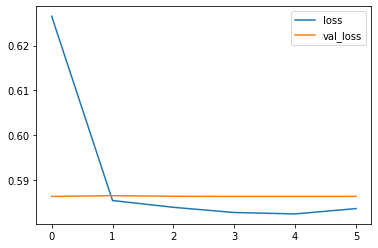

In [15]:
init_time = datetime.datetime.now()


STEPS_PER_EPOCH = train_gen.samples // BATCH_SIZE
VALIDATION_STEPS = val_gen.samples // BATCH_SIZE

early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, mode="max")
checkpoint = ModelCheckpoint("acc-{val_accuracy:.2f}.h5", monitor="val_accuracy", verbose=1, 
                             save_best_only=True, save_weights_only=True, mode="max")
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", factor=0.3, patience=1, 
                                            min_lr=1e-6, verbose=1, mode="max")


history = model.fit(
    feed_data(train_ds),
    validation_data=feed_data(val_ds),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps = VALIDATION_STEPS,
    callbacks=[checkpoint, early_stopping, learning_rate_reduction],
    verbose=1,
    )

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));



requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

In [16]:
test_steps = test_gen.samples // BATCH_SIZE

test_loss, test_acc = model.evaluate(test_ds, steps=test_steps)
print('\naccuracy:', test_acc, 'loss: ',test_loss)

73/73 [==============================] - 14s 185ms/step - loss: 0.5838 - accuracy: 0.7295

accuracy: 0.7294520735740662 loss:  0.5838034152984619


In [17]:
predict = model.predict(test_ds, steps=test_steps)
y_hat = np.where(predict > 0.5, 1, 0).ravel()
y_hat[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
test_labels_df = pd.DataFrame()
test_labels_df[['class']] = test_data[['class']]
test_labels_df['class'] = test_labels_df['class'].map({'NORMAL':0, 'PNEUMONIA':1})

y_test = np.array(test_labels_df['class'])
y_test[:20]

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1])

# Classifications.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       158
           1       0.73      1.00      0.84       426

    accuracy                           0.73       584
   macro avg       0.36      0.50      0.42       584
weighted avg       0.53      0.73      0.62       584
 



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

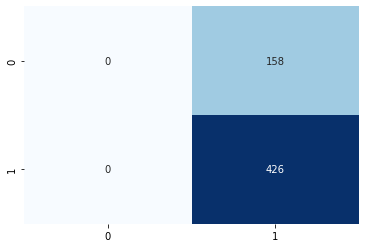

In [19]:
print(classification_report(y_test, y_hat), '\n')
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)